## **Сервис прогнозирования отмены в системе интернет-бронирования отелей**

Сначала мы попытаемся ответить на следующие вопросы
1. Сколько бронирований было отменено?
2. Каково соотношение бронирований между курортными и городскими отелями?
3. Каков процент бронирования за каждый год?
4. Какой месяц является наиболее загруженным для отеля?
5. Из какой страны приезжает больше всего гостей?
6. Как долго люди останавливаются в гостинице?
7. Какой тип размещения был забронирован чаще всего (одиночный, парный, семейный)?

После этого мы создадим прогностическую модель, чтобы предсказать, будет ли бронирование отменено или нет.

## Импортируем библиотеки


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC

pd.options.display.max_columns = None

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

In [ ]:
# Импортируем данные
data = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/hotel_bookings.csv')
#data = pd.read_csv('hotel_bookings.csv')

In [ ]:
# Функция для определения номера месяца по названию
def monthOrder(month):
  month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
  return month_order.index(month)
# Добавляем столбец для сортировки по месяцу
data['month_order'] = data.apply(lambda row: monthOrder(row['arrival_date_month']), axis=1)
# Сортируем данные
data.sort_values(by = ['arrival_date_year', 'month_order', 'arrival_date_day_of_month']  , axis=0, inplace=True)

In [ ]:
# Показажем первые 5 строк данных
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,month_order
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15,6
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15,6
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15,6
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15,6
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03-07-15,6


<hr>

## Предварительная обработка данных

In [ ]:
# Скопируем набор данных
df = data.copy()

### 1. Работа с отсутствующими значениями

In [ ]:
# Найдите пропущенное значение, покажите общее количество пропущенных значений 
# для каждого столбца и отсортируем их в порядке убывания
df.isnull().sum().sort_values(ascending=False)[:10]

company                           112593
agent                              16340
country                              488
children                               4
hotel                                  0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
days_in_waiting_list                   0
previous_bookings_not_canceled         0
dtype: int64

In [ ]:
# Удалим строки, в которых нет взрослых, детей и младенцев
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)


# Если идентификатор агента или компании не равен нулю, просто заменим его на 0
df[['agent','company']] = df[['agent','company']].fillna(0.0)


# Для отсутствующих значений в столбце "country" заменим его "OTHER"
df['country'].fillna("OTHER", inplace=True)


# Для отсутствующего значения детей, заменим его округленным средним значением
df['children'].fillna(round(data.children.mean()), inplace=True)

### 2. Преобразование типа данных

In [ ]:
# Преобразуем тип данных этих столбцов из float в integer
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

In [ ]:
df[['children', 'company', 'agent']]

,children,company,agent
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,304
4,0,0,240
...,...,...,...
119381,0,0,14
119383,0,0,42
119386,0,0,9
119387,0,0,9


In [ ]:
# Проверим, изабились ли от всех null значений
df.isnull().sum().sort_values(ascending=False)[:10]

hotel                          0
previous_cancellations         0
reservation_status_date        0
reservation_status             0
total_of_special_requests      0
required_car_parking_spaces    0
adr                            0
customer_type                  0
days_in_waiting_list           0
company                        0
dtype: int64

## EDA

In [ ]:
def get_count(series, limit=None):
    
    '''
    Args:
        series: series Pandas (один столбец из фрейма данных)
        limit: Если задано значение, ограничить выходное значение первыми предельными выборками.
    Returns:
        x = Уникальные значения
        y = Количество уникальных значений
    '''
    
    if limit != None:
        series = series.value_counts()[:limit]
    else:
        series = series.value_counts()
    
    x = series.index
    y = series/series.sum()*100
    
    return x.values,y.values

In [ ]:
def plot(x, y, x_label=None, y_label=None, title=None, figsize=None, plot_type='bar'):
    '''
    Построим график с указанными данными x и y.

    Args:
        x (в виде массива): Данные по оси x.
        y (массив-подобный): Данные оси y.
        x_label (str, необязательно): Метка оси x.
        y_label (str, необязательно): Метка оси y.
        title (str, необязательно): Заголовок графика.
        figsize (кортеж, необязательно): Размер графика в дюймах.
        plot_type (str, необязательно): Тип графика для создания ("bar" или "line").

    Returns:
        matplotlib.Axes: Объект оси графика.
    '''
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if figsize is not None:
        plt.figure(figsize=figsize)
    
    if plot_type == 'bar':
        ax = sns.barplot(x=x, y=y)
    elif plot_type == 'line':
        ax = sns.lineplot(x=x, y=y)
    else:
        raise ValueError(f"Недопустимый тип '{plot_type}'. Ожидается 'bar' или 'line'.")
    
    if x_label is not None:
        ax.set_xlabel(x_label)
    
    if y_label is not None:
        ax.set_ylabel(y_label)
    
    if title is not None:
        ax.set_title(title)
    
    return ax

### Теперь попробуем ответить на вопросы, которые задали выше

### 1. Сколько бронирований было отменено?

<Axes: xlabel='Бронирование отменено (Нет = 0, Да = 1)', ylabel='Бронирование (%)'>

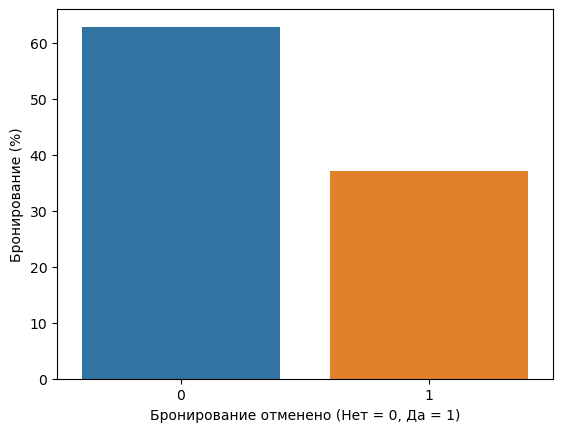

In [ ]:
x, y = get_count(df['is_canceled'])
plot(x, y, x_label='Бронирование отменено (Нет = 0, Да = 1)', y_label='Бронирование (%)')

Для дальнейшего анализа выберем только те бронирования, которые не были отменены.

In [ ]:
df_not_canceled = df[df['is_canceled'] == 0]

### 2. Каково соотношение бронирований между курортными и городскими отелями?

<Axes: title={'center': 'Сравнение отелей'}, xlabel='Отели', ylabel='Общее бронирование (%)'>

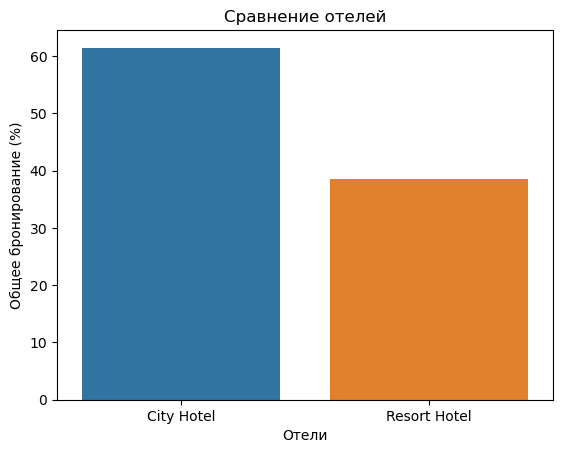

In [ ]:
x,y = get_count(df_not_canceled['hotel'])
plot(x,y, x_label='Отели', y_label='Общее бронирование (%)', title='Сравнение отелей')

### 3. Каков процент бронирования за каждый год?

<Axes: title={'center': 'Сравнение по годам'}, xlabel='Год', ylabel='Общее бронирование (%)'>

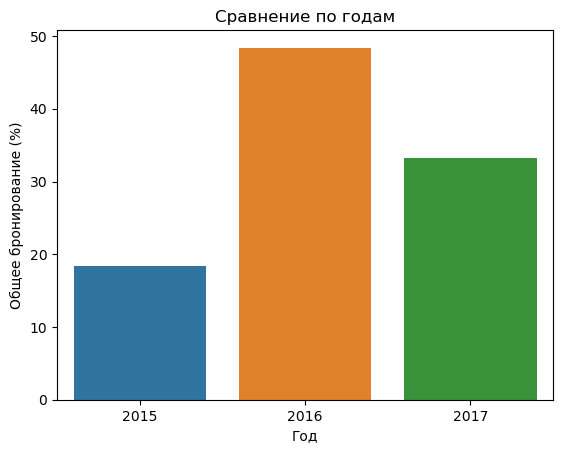

In [ ]:
x,y = get_count(df_not_canceled['arrival_date_year'])
plot(x,y, x_label='Год', y_label='Общее бронирование (%)', title='Сравнение по годам')

Разделим их по отелям

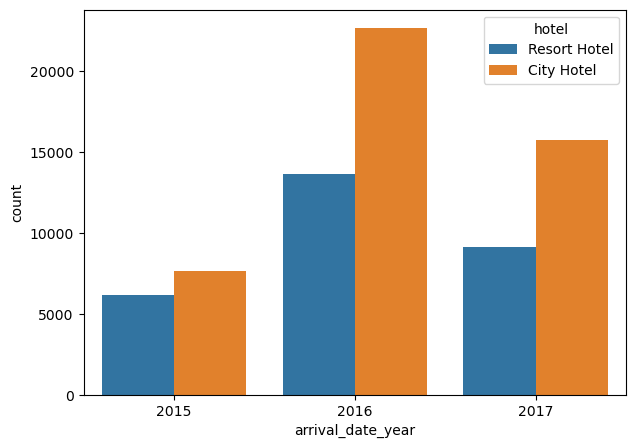

In [ ]:
plt.subplots(figsize=(7,5))
sns.countplot(x='arrival_date_year', hue='hotel',  data=df_not_canceled);

### 4. Какой месяц является наиболее загруженным для отеля?

<Axes: title={'center': 'Тенденция бронирования (ежемесячно)'}, xlabel='Месяцы', ylabel='Бронирование (%)'>

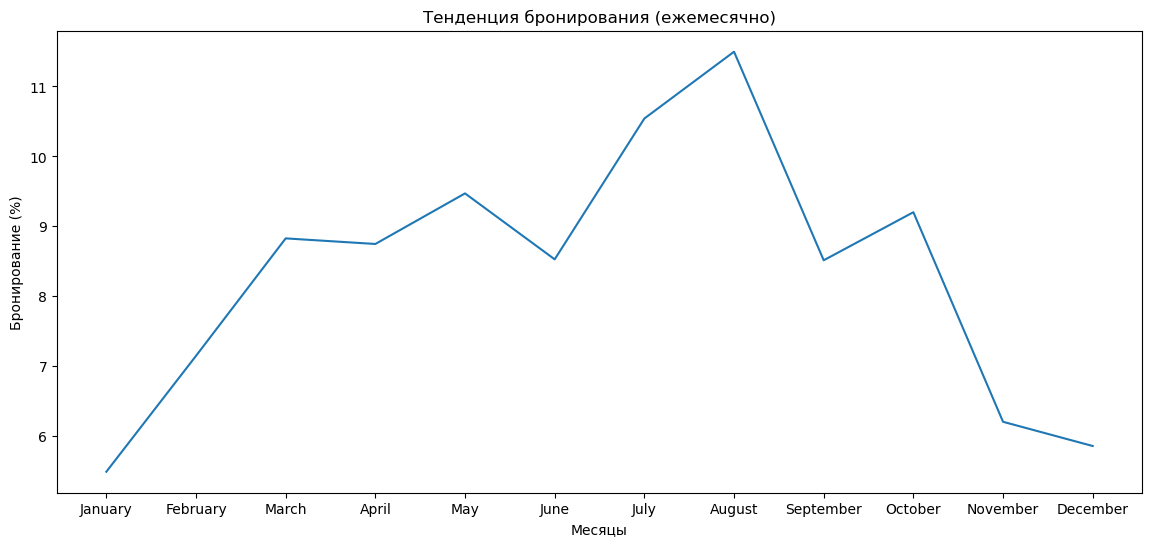

In [ ]:
# Порядок месяцев
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

sorted_months = df_not_canceled['arrival_date_month'].value_counts().reindex(new_order)

x = sorted_months.index
y = sorted_months/sorted_months.sum()*100

plot(x, y.values, x_label='Месяцы', y_label='Бронирование (%)', title='Тенденция бронирования (ежемесячно)', plot_type='line', figsize=(14,6))

<Axes: title={'center': 'Тенденция бронирования (ежемесячно)'}, xlabel='Месяцы', ylabel='Бронирование (%)'>

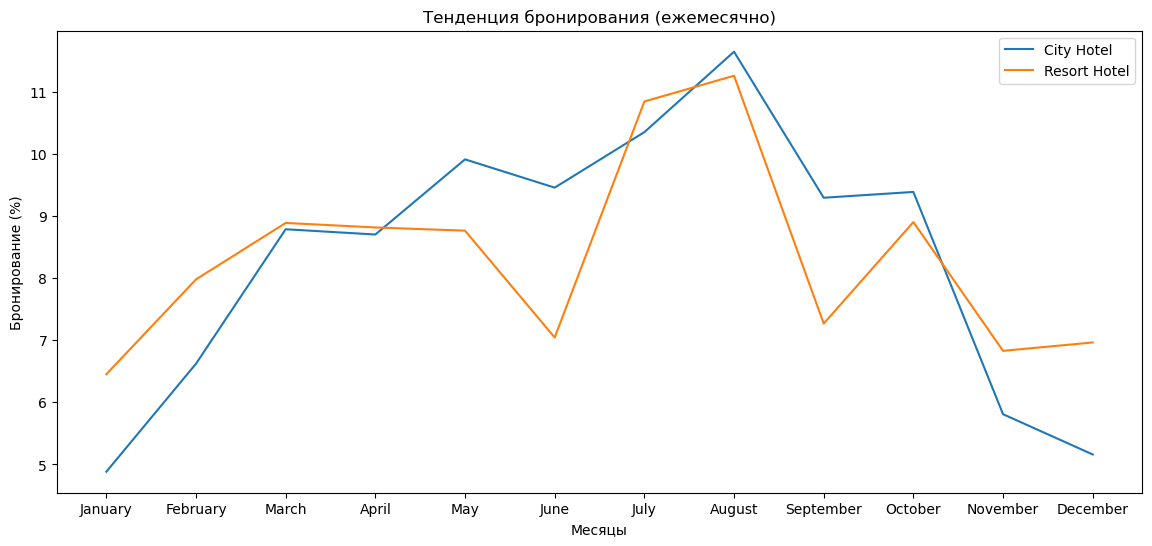

In [ ]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Выберем только городской отель
sorted_months = df_not_canceled.loc[df_not_canceled.hotel=='City Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)

x1 = sorted_months.index
y1 = sorted_months/sorted_months.sum()*100

# Выберем только курортный отель
sorted_months = df_not_canceled.loc[df_not_canceled.hotel=='Resort Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)

x2 = sorted_months.index
y2 = sorted_months/sorted_months.sum()*100


# Построим линейный график
fig, ax = plt.subplots(figsize=(14, 6))

ax.set_xlabel('Месяцы')
ax.set_ylabel('Бронирование (%)')
ax.set_title('Тенденция бронирования (ежемесячно)')

sns.lineplot(x=x1, y=y1.values, label='City Hotel', ax=ax)
sns.lineplot(x=x2, y=y2.values, label='Resort Hotel', ax=ax)

### 5. Из какой страны приезжает больше всего гостей?

**`pycountry`** — очень полезный пакет Python.  
Мы будем использовать этот пакет для получения названий стран из кодов стран

In [ ]:
!pip install pycountry

<Axes: title={'center': 'Сравнение по странам'}, xlabel='Страны', ylabel='Общее бронирование (%)'>

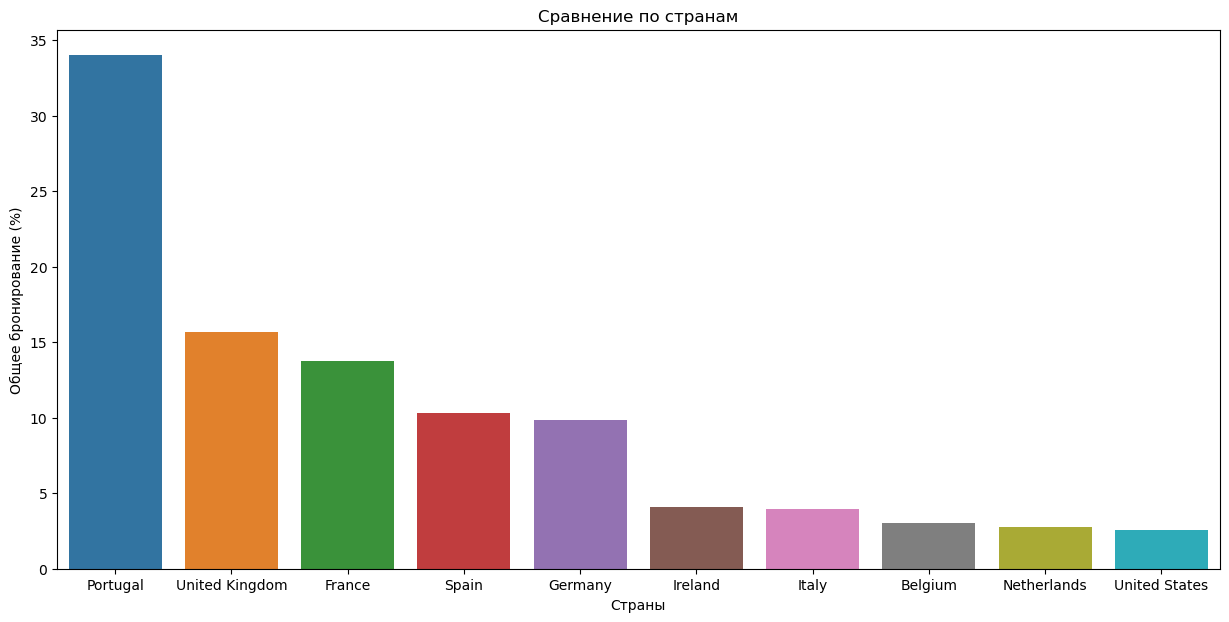

In [ ]:
import pycountry as pc

x,y = get_count(df_not_canceled['country'], limit=10)

# Для каждого кода страны выберите название страны
country_name = [pc.countries.get(alpha_3=name).name for name in x]

plot(country_name,y, x_label='Страны', y_label='Общее бронирование (%)', title='Сравнение по странам', figsize=(15,7))

### 6. Как долго люди останавливаются в гостинице?

<Axes: title={'center': 'Продолжительность пребывания (Топ-10)'}, xlabel='Количество ночей', ylabel='Процент бронирования (%)'>

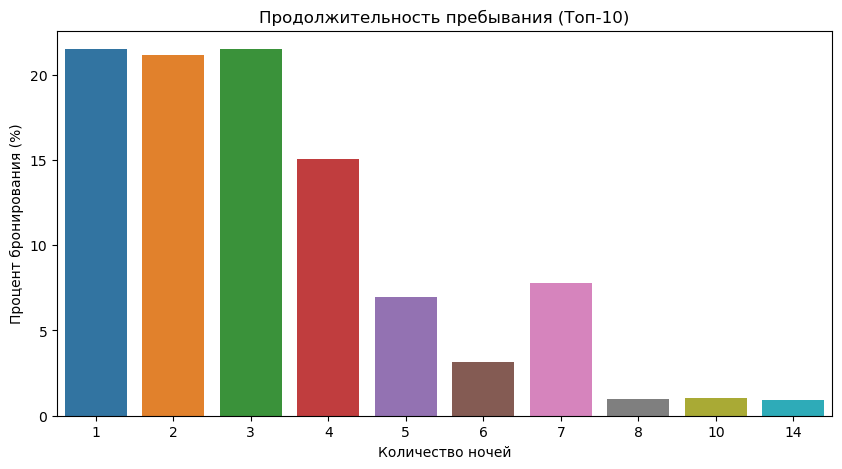

In [ ]:
total_nights = df_not_canceled['stays_in_weekend_nights']+ df_not_canceled['stays_in_week_nights']
x,y = get_count(total_nights, limit=10)

plot(x,y, x_label='Количество ночей', y_label='Процент бронирования (%)', title='Продолжительность пребывания (Топ-10)', figsize=(10,5))

<Axes: title={'center': 'Продолжительность пребывания в отеле (Топ-10)'}, xlabel='total_nights', ylabel='count'>

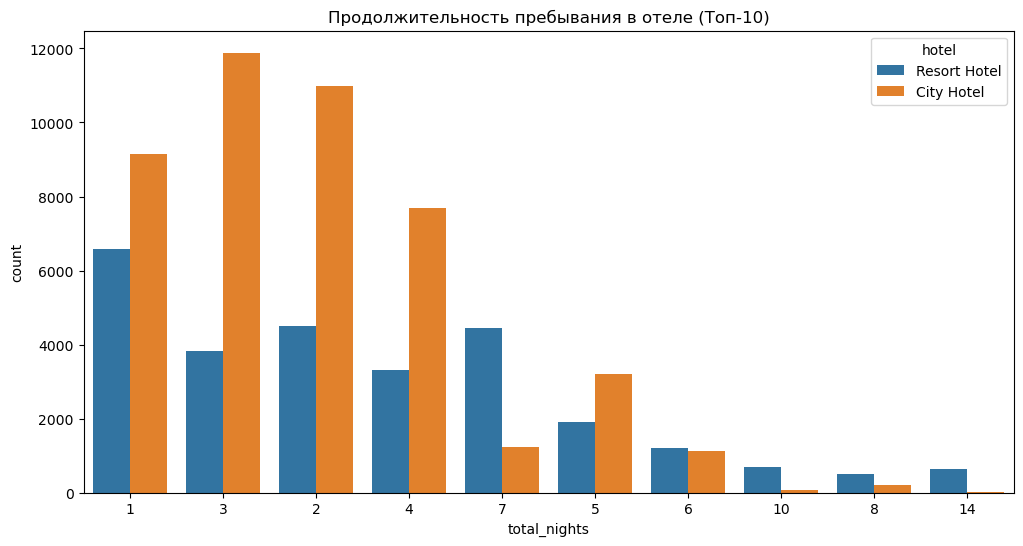

In [ ]:
df_not_canceled_new = df_not_canceled.copy()
df_not_canceled_new.loc[:, 'total_nights'] = df_not_canceled_new.loc[:, 'stays_in_weekend_nights'] + df_not_canceled_new.loc[:, 'stays_in_week_nights']

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Количество ночей')
ax.set_ylabel('Количество бронирований')
ax.set_title('Продолжительность пребывания в отеле (Топ-10)')
sns.countplot(x='total_nights', hue='hotel', data=df_not_canceled_new,
              order=df_not_canceled_new.total_nights.value_counts().iloc[:10].index, ax=ax)

### 7. Какой тип размещения был забронирован чаще всего (одиночный, парный, семейный)?

<Axes: title={'center': 'Тип размещения'}, ylabel='Бронирование (%)'>

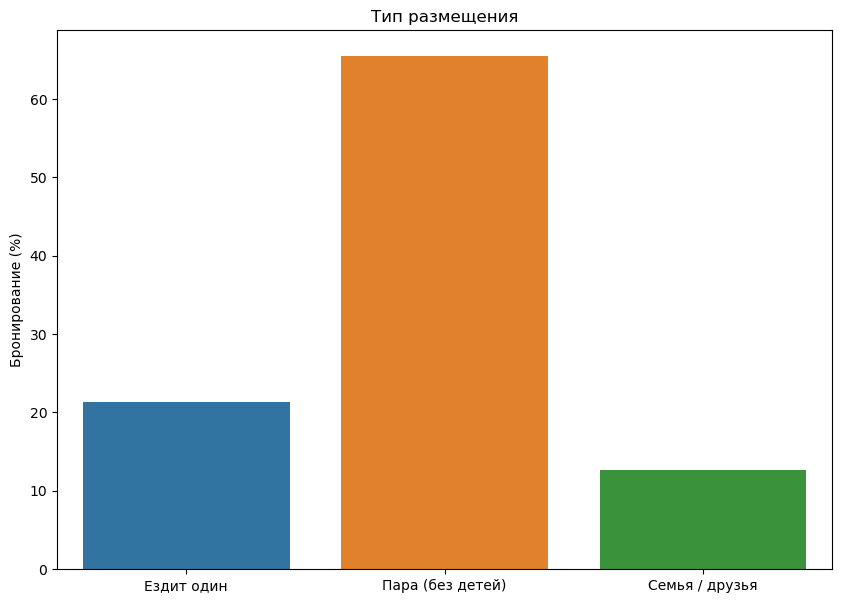

In [ ]:
# Выберем кто ездит один, пару и семью
single   = df_not_canceled[(df_not_canceled.adults==1) & (df_not_canceled.children==0) & (df_not_canceled.babies==0)]
couple   = df_not_canceled[(df_not_canceled.adults==2) & (df_not_canceled.children==0) & (df_not_canceled.babies==0)]
family   = df_not_canceled[df_not_canceled.adults + df_not_canceled.children + df_not_canceled.babies > 2]

# Составим список названий категорий и их общего процента
names = ['Ездит один', 'Пара (без детей)', 'Семья / друзья']
count = [single.shape[0],couple.shape[0], family.shape[0]]
count_percent = [x/df_not_canceled.shape[0]*100 for x in count]

plot(names,count_percent,  y_label='Бронирование (%)', title='Тип размещения', figsize=(10,7))

Для дальнейшего анализа необходимо выяснить, является ли существенной информация о предыдущих отменах бронирования.

1. Определим, какова доля отмен бронирования для клиентов, которые уже отменяли бронирования ранее.
2. Сравним ее с таким же показателем, но для клиентов, которые не отменяли бронирование но хотя бы раз бронировали отель ранее.

In [ ]:
df_canceled = df[df['previous_cancellations'] > 0]
df_canceled.groupby('is_canceled').size() / len(df_canceled)

is_canceled
0    0.083192
1    0.916808
dtype: float64

In [ ]:
df_not_canceled_before = df[(df['previous_cancellations'] == 0) & (df['previous_bookings_not_canceled'] > 0)]
df_not_canceled_before.groupby('is_canceled').size() / len(df_not_canceled_before)

is_canceled
0    0.976423
1    0.023577
dtype: float64

Видим, что более чем в 90% случаев, клиенты, которые отменяли бронирование ранее, отменяют его снова. В то время как для тех клиентов, которые ни разу не отменяли бронирование эта вероятность чуть более 2%. Очевидно, что это важный показатель, который нельзя сбрасывать о счетов.

<hr>

## Feature Selection и Feature Engineering

In [ ]:
# Скопируем датасет
df_subset = df.copy()

In [ ]:
# Удалите колонку booking_status
# потому что она сообщает нам, было ли бронирование отменено
df_subset = df_subset.drop(['reservation_status'], axis=1)

In [ ]:
# Создаем новый столбец, который содержит 1, если гость получил тот же номер, который был зарезервирован, иначе 0
df_subset['Room'] = 0
df_subset.loc[ df_subset['reserved_room_type'] == df_subset['assigned_room_type'] , 'Room'] = 1

## Создаем новый столбец, который будет содержать 1, если гость отменил больше бронирований в прошлом
## чем количество бронирований, которые он не отменял, в противном случае 0

df_subset['net_cancelled'] = 0
df_subset.loc[ df_subset['previous_cancellations'] > df_subset['previous_bookings_not_canceled'] , 'net_cancelled'] = 1

In [ ]:
# На основании характеристик previous_cancellations и previous_bookings_not_canceled создадим новую характеристику - процент отмен
df_subset['cancellation_ratio'] = np.where(df_subset['previous_cancellations'] + df_subset['previous_bookings_not_canceled'] > 0,
                                           df_subset['previous_cancellations'] / (df_subset['previous_cancellations'] + df_subset['previous_bookings_not_canceled']),
                                           0)

После проведения исследовательского анализа данных (EDA), мы решили удалить следующие менее важные характеристики из набора данных:

`arrival_date_year`, `arrival_date_week_number`, `arrival_date_day_of_month`, и `arrival_date_month`: Удаляем эти признаки, потому что они представляют дату прибытия с различными уровнями детализации

`assigned_room_type` и `reserved_room_type`: Эти две характеристики представляют тип назначенного и зарезервированного номера. Они часто коррелируют, и удаление одного из них поможет уменьшить мультиколлинеарность в наших данных

`reservation_status_date`: Удаляем этот признак, так как он описывает дату обновления статуса бронирования и имеет слабую связь с отменой бронирования.

Удаление этих менее важных характеристик позволит нам сосредоточиться на наиболее важных факторах, которые влияют на отмену бронирования, улучшить производительность модели и упростить интерпретацию результатов.

In [ ]:
# Удалим менее важные фичи
df_subset = df_subset.drop(['arrival_date_week_number','assigned_room_type','reserved_room_type','reservation_status_date'],axis=1)

Еще раз просмотрим количественный состав по странам

In [ ]:
df_subset['country'].value_counts()[:10]

PRT    48483
GBR    12120
FRA    10401
ESP     8560
DEU     7285
ITA     3761
IRL     3374
BEL     2342
BRA     2222
NLD     2103
Name: country, dtype: int64

Видим, что наибольший вклад вносят первые 5 стран. Объединим остальные страны в одну категорию `OTHER`.

In [ ]:
countries = df_subset['country'].value_counts()[:5].keys().to_list()

In [ ]:
df_subset['country_group'] = np.where(df_subset['country'].isin(countries),
                                           df_subset['country'],
                                           "OTHER")

Удалим лишнюю характеристику `country`.

In [ ]:
df_subset = df_subset.drop(['country'],axis=1)

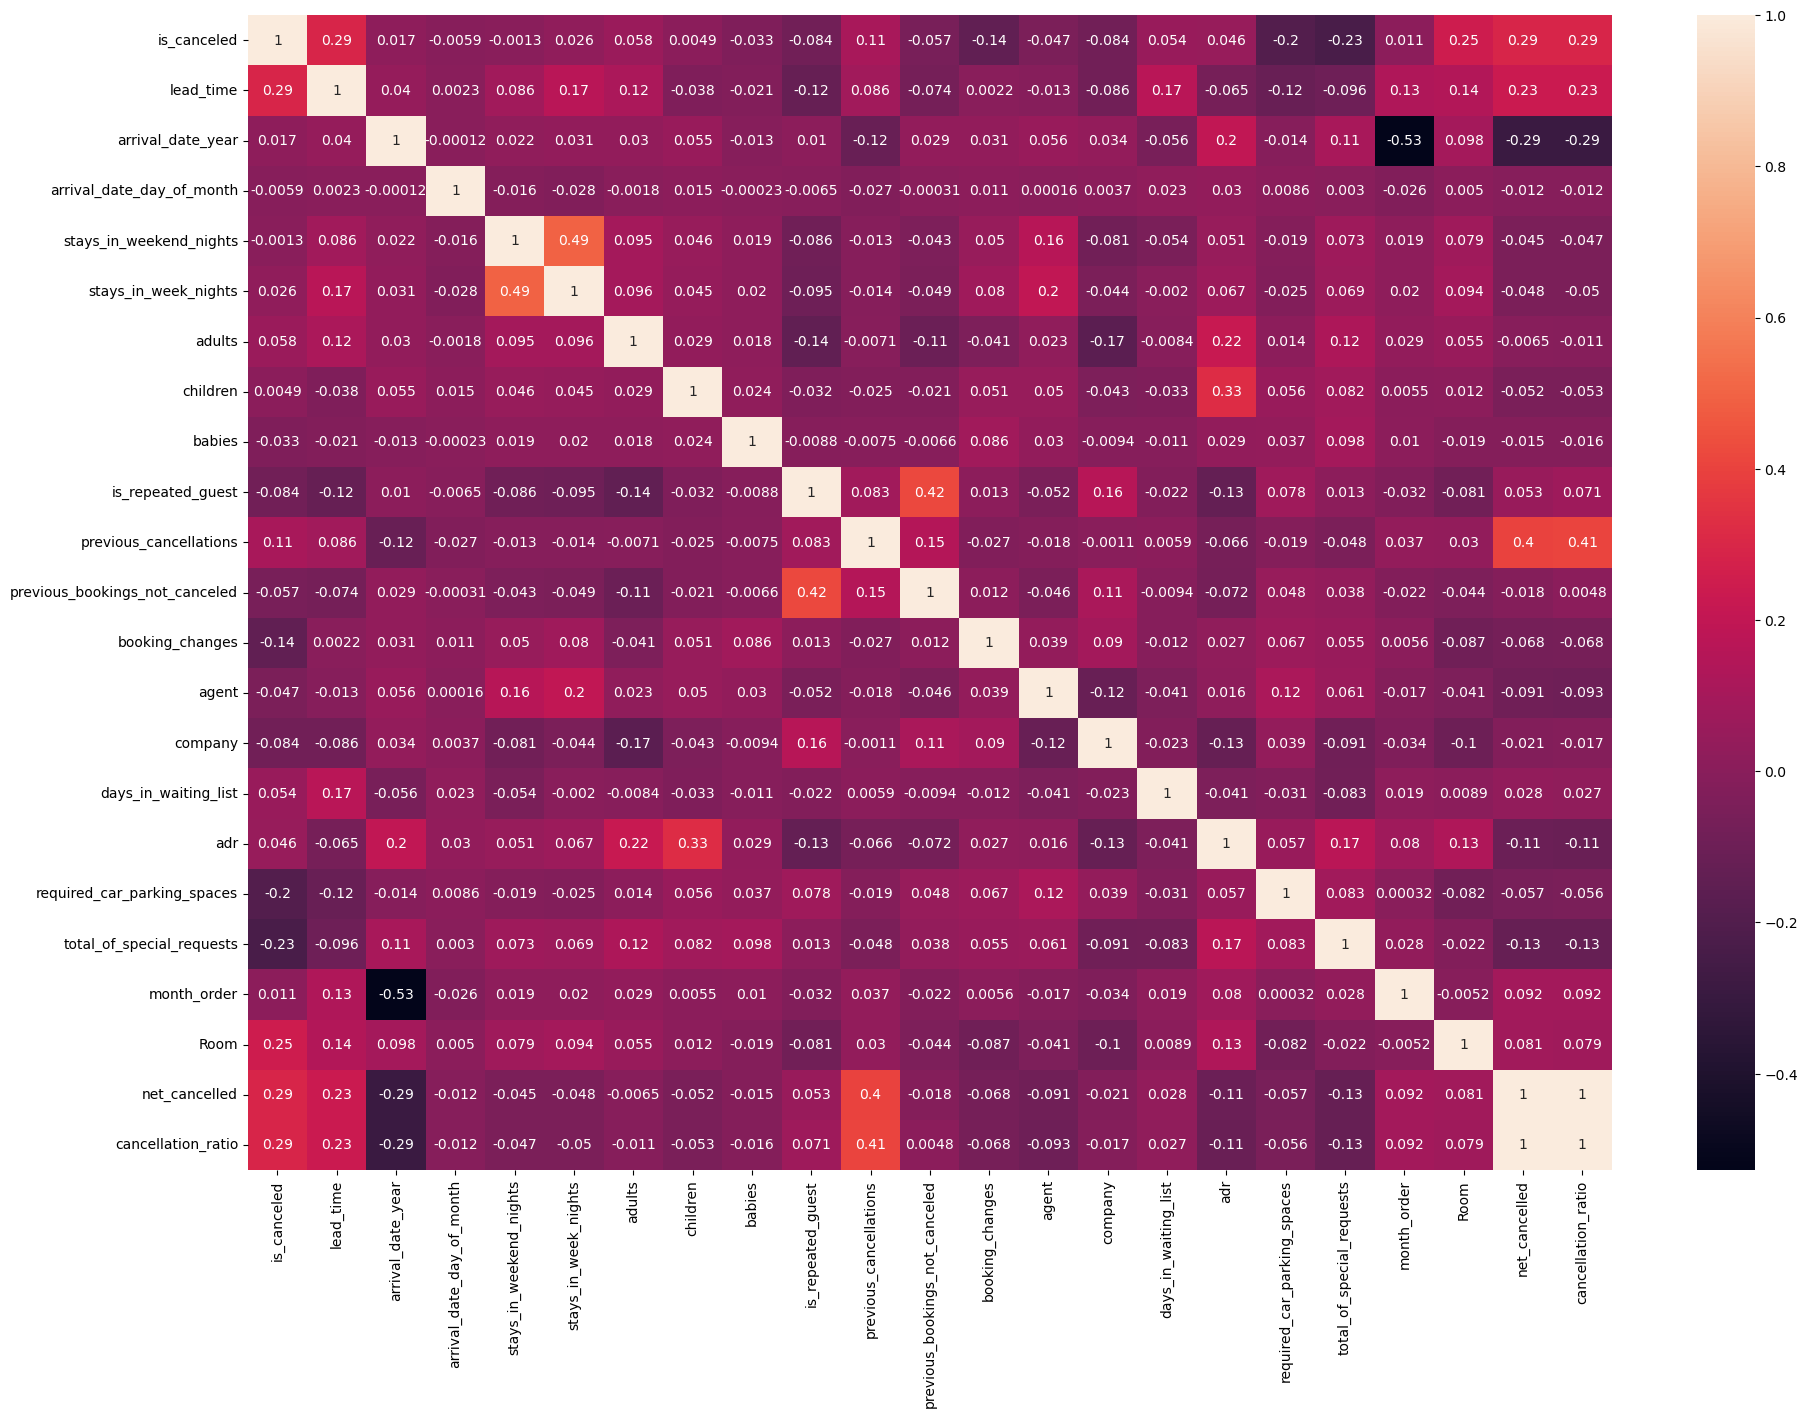

In [ ]:
# Построим тепловую карту, чтобы увидеть корреляцию с колонками
fig, ax = plt.subplots(figsize=(22,15))
sns.heatmap(df_subset.corr(numeric_only=True), annot=True, ax=ax);

<hr>


Анализируя тепловую карту видим, что новая характеристика `cancellation_ratio` гораздо лучше коррелирует с `is_canceled` чем `previous_bookings_not_canceled` и `previous_cancellations`. В то же время видим, что корреляция между `cancellation_ratio` и `net_cancelled` составляет 1. Таким образом мы можем удалить все три показателя `cancellation_ratio`, `previous_cancellations` и `previous_bookings_not_canceled`, оставив только `net_cancelled`.

In [ ]:
df_subset = df_subset.drop(['previous_cancellations','previous_bookings_not_canceled', 'cancellation_ratio'],axis=1)

Чтобы избежать переобучения модели удалим так же наименее значимые характеристики корреляция которых с `is_canceled` меньше 0,1

In [ ]:
#df_subset = df_subset.drop(['stays_in_week_nights', 'stays_in_weekend_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'agent','company', 'adr', 'days_in_waiting_list'],axis=1)

## Моделирование

### 1. Преобразование категориальных переменных в числовые

In [ ]:
def transform(dataframe):
    le = LabelEncoder()
    
    # Выберем все категориальные признаки
    categorical_features = list(dataframe.columns[dataframe.dtypes == object])
    
    # Применим кодирование меток ко всем категориальным признакам
    return dataframe[categorical_features].apply(lambda x: le.fit_transform(x))

df = transform(df)

### 2. Разбиваем на обучающую и тестовую выборку

Для задачи предсказания отмены бронирования номеров в отеле мы будем использовать метод `train_test_split` для разделения данных на обучающую и тестовую выборки, поскольку он предоставляет следующие преимущества:


*   Независимость от временной структуры: В данной задаче временная структура данных может не иметь первостепенного значения, поскольку предсказание отмены бронирования скорее связано с характеристиками самого бронирования и клиентов, а не с их последовательностью во времени. Использование `train_test_split` обеспечивает случайное разделение данных, что позволяет получить обучающую и тестовую выборки, представляющие разнообразные примеры безотносительно времени

*   Предотвращение переобучения: `train_test_split` перемешивает данные перед разделением, что предотвращает возможное переобучение модели. Это гарантирует, что обучающая выборка содержит достаточно разнообразие, чтобы модель могла уловить основные закономерности, а тестовая выборка позволяет оценить обобщающую способность модели на новых данных.

*   Быстрота и простота: Использование `train_test_split` является простым и быстрым методом разделения данных, который обеспечивает хороший компромисс между эффективностью и точностью модели. Это позволяет сосредоточиться на самом процессе обучения и подборе оптимальных гиперпараметров, а также упрощает поддержку и внедрение модели в продуктивную среду.


Таким образом, использование `train_test_split` для разделения данных на обучающую и тестовую выборки обеспечивает эффективный и надежный способ для обучения и оценки модели предсказания отмены бронирования номеров в отеле. Этот метод обеспечивает хороший баланс между простотой, скоростью и точностью.

Заметим, что на практике нам будут известны только данные за прошедшие периоды и прогнозы мы должны строить опираясь на них. В этом случае в качестве обучающей выборки будем брать только данные из первой части набора данных, а в качестве тестовой - вторую часть, чтобы моделировать эту ситуацию.

In [ ]:
def data_split(df, label, split_on=0):
    '''
    Разделим входной массив данных на обучающий и тестовый наборы и выполнить 
    одномоментное кодирование для категориальных переменных.

    Args:
        df (pandas.DataFrame): Входной фрейм данных.
        label (str): Имя столбца целевой метки.

    Returns:
        Кортеж из четырех элементов, содержащий обучающие и тестирующие признаки и метки.
    '''
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder

    X = df.drop(label, axis=1)
    Y = df[label]

    # Разделение на обучающее и тестирующее множества
    if split_on == 0: # Используем train_test_split с перемешиванием
      x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0)
    else: # Делим не перемешивая, а потом перемешиваем обучающую и тестовую выборки отдельно
      x_train = df_subset.iloc[:split_on].sample(frac=1)
      x_test = df_subset.iloc[split_on:].sample(frac=1)
      y_train = x_train.pop(label)
      y_test = x_test.pop(label)

    # Одномоментное кодирование категориальных переменных
    categorical_cols = X.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoder.fit(x_train[categorical_cols])
        x_train_encoded = encoder.transform(x_train[categorical_cols]).toarray()
        x_test_encoded = encoder.transform(x_test[categorical_cols]).toarray()
        x_train = x_train.drop(categorical_cols, axis=1)
        x_test = x_test.drop(categorical_cols, axis=1)
        x_train = np.hstack((x_train, x_train_encoded))
        x_test = np.hstack((x_test, x_test_encoded))

    return x_train, x_test, y_train, y_test

Проверим, что выборки корректно формируются при разбиении по дате. Для этого выберем самую позднюю дату из обучающей выборки и самую раннюю - из тестовой. Первая должна быть не больше второй.

In [ ]:
split_on = 90000
label = 'is_canceled'
x_train = df_subset.iloc[:split_on].sample(frac=1)
x_test = df_subset.iloc[split_on:].sample(frac=1)
y_train = x_train.pop(label)
y_test = x_test.pop(label)

In [ ]:
x_train.sort_values(by = ['arrival_date_year', 'month_order', 'arrival_date_day_of_month']  , axis=0, inplace=True)
x_train[['arrival_date_day_of_month','arrival_date_month','arrival_date_year']].tail(1)

,arrival_date_day_of_month,arrival_date_month,arrival_date_year
65035,23,March,2017


In [ ]:
x_test.sort_values(by = ['arrival_date_year', 'month_order', 'arrival_date_day_of_month']  , axis=0, inplace=True)
x_test[['arrival_date_day_of_month','arrival_date_month','arrival_date_year']].head(1)

,arrival_date_day_of_month,arrival_date_month,arrival_date_year
65042,23,March,2017


Даты нам больше не нужны. Удалим их.

In [ ]:
df_subset = df_subset.drop(['month_order','arrival_date_year','arrival_date_day_of_month','arrival_date_month'],axis=1)

### Модель машинного обучения

In [ ]:
from sklearn.model_selection import GridSearchCV

def train(x_train, y_train, model_type='random_forest', random_state=0, estimators=[]):
    """
    Обучаем модели классификации на входных признаках и метках с помощью заданного алгоритма.

    Args:
        x_train (pandas.DataFrame): Фрейм данных, содержащий входные признаки.
        y_train (pandas.Series): Серия, содержащая целевые метки.
        x_test (pandas.DataFrame): Фрейм данных, содержащий входные признаки для тестирования.
        y_test (pandas.Series): Серия, содержащая целевые метки для тестирования.
        model_type (str): Тип используемой модели. Может быть 'random_forest',
        'linear_regression', 'voting_classifier', 'logistic_regression' или 'SVM'. По умолчанию - 'random_forest'.
        random_state (int): Случайное зерно, используемое для воспроизводимости. По умолчанию 0.

    Returns:
        Обученный объект модели scikit-learn или CatBoost.
    """
    if model_type == 'random_forest':
        model = RandomForestClassifier(random_state=random_state)
    elif model_type == 'linear_regression':
        model = LinearRegression()
    elif model_type == 'voting_classifier':
        model = VotingClassifier(estimators=estimators, voting='soft')
    elif model_type == 'logistic_regression':
        model = LogisticRegression(solver='newton-cholesky', max_iter=500)
    elif model_type == 'SVM':
        model = SVC(kernel='sigmoid', gamma='auto', probability=True)
    else:
        raise ValueError(f"Неверный тип модели: {model_type}")

    model.fit(x_train, y_train)

    return model

### 4. Оценка модели

In [ ]:
def Score(clf, x_train, y_train, x_test, y_test):
    # Вычислим точность обучения и тестирования
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)

    # Вычислим тренировочную и тестовую ROC-кривую и AUC
    train_probs = clf.predict_proba(x_train)[:, 1]
    test_probs = clf.predict_proba(x_test)[:, 1]
    train_fpr, train_tpr, _ = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, _ = roc_curve(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)

    # Вывод оценок и построение ROC-кривых
    print("========================================")
    print(f'Точность на обучающей выборке: {train_score}')
    print(f'Точность на тестовой выборке: {test_score}')
    print(f'Training AUC нашей модели: {train_auc}')
    print(f'Testing AUC нашей модели: {test_auc}')
    print("========================================")

### Обучим CatBoost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
def data_split_cat(df, label, split_on=[]):
    '''
    Разделим входной массив данных на обучающий, тестовый и валидационный наборы.

    Args:
        df (pandas.DataFrame): Входной фрейм данных.
        label (str): Имя столбца целевой метки.

    Returns:
        Кортеж из шести элементов, содержащий обучающие, тестовые и валидационные признаки и метки.
    '''
    from sklearn.model_selection import train_test_split

    X = df.drop(label, axis=1)
    Y = df[label]

    if split_on == []:
      # Разделение на тренировочное и тестовое множества
      x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
      # Разделение на тренировочное и валидационное множества
      x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
    else:
      x_train = df_subset.iloc[:split_on[0]].sample(frac=1)
      x_test = df_subset.iloc[split_on[0]:split_on[1]].sample(frac=1)
      x_val = df_subset.iloc[split_on[1]:].sample(frac=1)
      y_train = x_train.pop(label)
      y_test = x_test.pop(label)      
      y_val = x_val.pop(label)

    return x_train, x_test, x_val, y_train, y_test, y_val

In [ ]:
# Разделение на тренировочное, тестовое и валидационное множества
x_trains, x_tests, x_vals, y_trains, y_tests, y_vals = data_split_cat(df_subset, 'is_canceled')

In [ ]:
# Указание категориальных признаков
cat_features = ['hotel', 'meal', 'country_group', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']

# Создание и обучение модели CatBoost
clf5 = CatBoostClassifier(loss_function='Logloss', random_seed=0)
clf5.fit(x_trains, y_trains, eval_set=(x_vals, y_vals), cat_features=cat_features, verbose=100)

# Оценка качества модели на тестовом множестве
test_score = clf5.score(x_tests, y_tests)
print(f'Test score: {test_score:.3f}')

Learning rate set to 0.092445
0:	learn: 0.6202483	test: 0.6207496	best: 0.6207496 (0)	total: 303ms	remaining: 5m 2s
100:	learn: 0.2993930	test: 0.3035068	best: 0.3035068 (100)	total: 9.34s	remaining: 1m 23s
200:	learn: 0.2843631	test: 0.2922456	best: 0.2922456 (200)	total: 17.5s	remaining: 1m 9s
300:	learn: 0.2747696	test: 0.2862449	best: 0.2862449 (300)	total: 25.4s	remaining: 59.1s
400:	learn: 0.2678133	test: 0.2833534	best: 0.2833534 (400)	total: 33.9s	remaining: 50.6s
500:	learn: 0.2622530	test: 0.2814284	best: 0.2814284 (500)	total: 42s	remaining: 41.9s
600:	learn: 0.2580309	test: 0.2799245	best: 0.2799233 (599)	total: 50.4s	remaining: 33.4s
700:	learn: 0.2540209	test: 0.2787470	best: 0.2787444 (699)	total: 58.6s	remaining: 25s
800:	learn: 0.2504099	test: 0.2776637	best: 0.2776619 (799)	total: 1m 7s	remaining: 16.6s
900:	learn: 0.2463106	test: 0.2764354	best: 0.2764265 (899)	total: 1m 15s	remaining: 8.31s
999:	learn: 0.2432804	test: 0.2756631	best: 0.2756631 (999)	total: 1m 23s	re

In [ ]:
Score(clf5,x_trains,y_trains, x_tests, y_tests)

Точность на обучающей выборке: 0.8909088525965344
Точность на тестовой выборке: 0.8743394010569583
Training AUC нашей модели: 0.9607660015243383
Testing AUC нашей модели: 0.9488127762525101


Повторим моделирование для ситуации, где известны только данные за прошедшие периоды.

In [ ]:
x_trains2, x_tests2, x_vals2, y_trains2, y_tests2, y_vals2 = data_split_cat(df_subset, 'is_canceled', [90000, 100000])
clf5_ = CatBoostClassifier(loss_function='Logloss', random_seed=0)
clf5_.fit(x_trains2, y_trains2, eval_set=(x_vals2, y_vals2), cat_features=cat_features, verbose=100)
test_score = clf5_.score(x_tests2, y_tests2)
print(f'Test score: {test_score:.3f}')

Learning rate set to 0.096296
0:	learn: 0.6180933	test: 0.6528154	best: 0.6528154 (0)	total: 99ms	remaining: 1m 38s
100:	learn: 0.2758470	test: 0.4189130	best: 0.4189130 (100)	total: 9.14s	remaining: 1m 21s
200:	learn: 0.2577596	test: 0.4143716	best: 0.4133453 (186)	total: 17.9s	remaining: 1m 11s
300:	learn: 0.2480652	test: 0.4148916	best: 0.4133453 (186)	total: 27.2s	remaining: 1m 3s
400:	learn: 0.2417508	test: 0.4161118	best: 0.4133453 (186)	total: 37.4s	remaining: 55.9s
500:	learn: 0.2359084	test: 0.4190288	best: 0.4133453 (186)	total: 47.4s	remaining: 47.2s
600:	learn: 0.2314632	test: 0.4199162	best: 0.4133453 (186)	total: 56.9s	remaining: 37.7s
700:	learn: 0.2271516	test: 0.4205722	best: 0.4133453 (186)	total: 1m 5s	remaining: 28.1s
800:	learn: 0.2238819	test: 0.4218167	best: 0.4133453 (186)	total: 1m 15s	remaining: 18.7s
900:	learn: 0.2201474	test: 0.4245834	best: 0.4133453 (186)	total: 1m 24s	remaining: 9.28s
999:	learn: 0.2172268	test: 0.4264926	best: 0.4133453 (186)	total: 1m 

### Обучим случайный лес

In [ ]:
# Разделение на тренировочное, тестовое и валидационное множества
x_train, x_test, y_train, y_test = data_split(df_subset, 'is_canceled')

In [ ]:
clf2 = train(x_train, y_train, model_type='random_forest')

In [ ]:
Score(clf2,x_train, y_train, x_test, y_test)

Точность на обучающей выборке: 0.9954030445043452
Точность на тестовой выборке: 0.8850786833540247
Training AUC нашей модели: 0.9995931449948194
Testing AUC нашей модели: 0.953514972328194


То же самое для неизвестных будущих периодов.

In [ ]:
# Разделение на тренировочное, тестовое и валидационное множества
x_train2, x_test2, y_train2, y_test2 = data_split(df_subset, 'is_canceled', 90000)

In [ ]:
clf2_ = train(x_train2, y_train2, model_type='random_forest')
Score(clf2_, x_train2, y_train2, x_test2, y_test2)

Точность на обучающей выборке: 0.9942222222222222
Точность на тестовой выборке: 0.7947278329339268
Training AUC нашей модели: 0.9995058596289385
Testing AUC нашей модели: 0.8783856143719562


### Обучим линейную регрессию

In [ ]:
clf3 = train(x_train, y_train, model_type='linear_regression')

In [ ]:
def ScoreLinear(clf, x_train, y_train, x_test, y_test):
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    
    train_r2 = r2_score(y_train, clf.predict(x_train))
    test_r2 = r2_score(y_test, clf.predict(x_test))
    train_mse = mean_squared_error(y_train, clf.predict(x_train))
    test_mse = mean_squared_error(y_test, clf.predict(x_test))

    print("========================================")
    print(f"Оценка R^2 для обучения: {train_r2:.4f}")
    print(f"MSE обучения: {train_mse:.4f}")
    print(f"Результат обучения: {train_score:.4f}")
    print("========================================")
    print(f"Оценка R^2 теста: {test_r2:.4f}")
    print(f"MSE теста: {test_mse:.4f}")
    print(f"Оценка теста: {test_score:.4f}")
    print("========================================")

In [ ]:
ScoreLinear(clf3,x_train, y_train, x_test, y_test)

Оценка R^2 для обучения: 0.4256
MSE обучения: 0.1340
Результат обучения: 0.4256
Оценка R^2 теста: 0.4260
MSE теста: 0.1338
Оценка теста: 0.4260


То же самое для неизвестных будущих периодов.

In [ ]:
clf3_ = train(x_train2, y_train2, model_type='linear_regression')
ScoreLinear(clf3_, x_train2, y_train2, x_test2, y_test2)

Оценка R^2 для обучения: 0.4487
MSE обучения: 0.1268
Результат обучения: 0.4487
Оценка R^2 теста: 0.3467
MSE теста: 0.1577
Оценка теста: 0.3467


### Обучим Логистическую регрессию

In [ ]:
def LogReport(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

    report = classification_report(y_test, y_pred)
    print(report)

In [ ]:
clf_log = train(x_train, y_train, model_type='logistic_regression')

Accuracy: 81.39%
Confusion matrix:
 [[17110  1657]
 [ 3888  7148]]


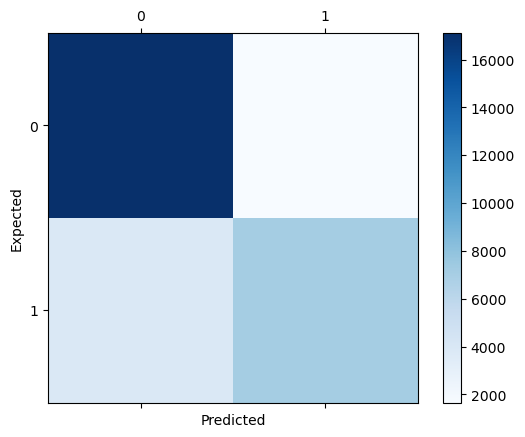

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     18767
           1       0.81      0.65      0.72     11036

    accuracy                           0.81     29803
   macro avg       0.81      0.78      0.79     29803
weighted avg       0.81      0.81      0.81     29803



In [ ]:
LogReport(clf_log, x_test, y_test)

То же самое для неизвестных будущих периодов.

In [ ]:
clf_log_ = train(x_train2, y_train2, model_type='logistic_regression')

Accuracy: 77.07%
Confusion matrix:
 [[15306  2008]
 [ 4689  7207]]


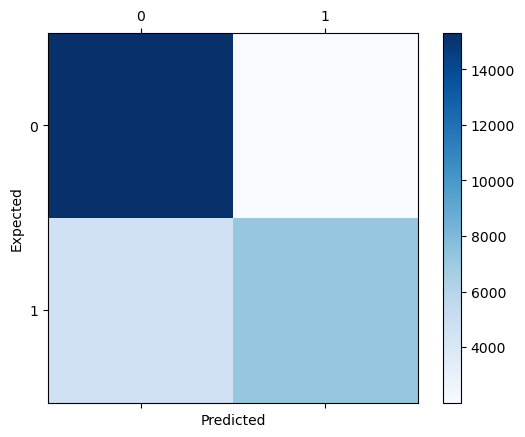

              precision    recall  f1-score   support

           0       0.77      0.88      0.82     17314
           1       0.78      0.61      0.68     11896

    accuracy                           0.77     29210
   macro avg       0.77      0.74      0.75     29210
weighted avg       0.77      0.77      0.76     29210



In [ ]:
LogReport(clf_log_, x_test2, y_test2)

### Обучим SVM

In [ ]:
clf_SVM = train(x_train, y_train, model_type='SVM')

Accuracy: 46.63%
Confusion matrix:
 [[10757  8010]
 [ 7896  3140]]


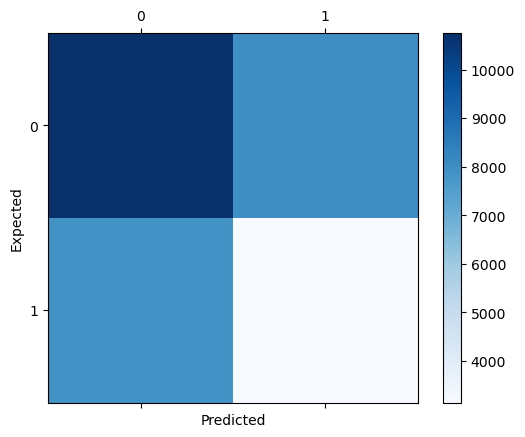

              precision    recall  f1-score   support

           0       0.58      0.57      0.57     18767
           1       0.28      0.28      0.28     11036

    accuracy                           0.47     29803
   macro avg       0.43      0.43      0.43     29803
weighted avg       0.47      0.47      0.47     29803



In [ ]:
LogReport(clf_SVM, x_test, y_test)

То же самое для неизвестных будущих периодов.

In [ ]:
clf_SVM_ = train(x_train2, y_train2, model_type='SVM')

Accuracy: 49.66%
Confusion matrix:
 [[12645  4669]
 [10035  1861]]


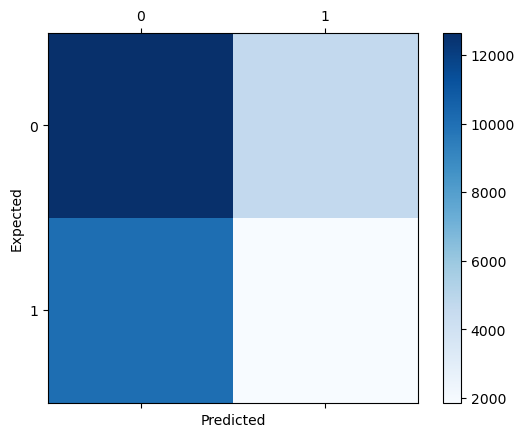

              precision    recall  f1-score   support

           0       0.56      0.73      0.63     17314
           1       0.28      0.16      0.20     11896

    accuracy                           0.50     29210
   macro avg       0.42      0.44      0.42     29210
weighted avg       0.45      0.50      0.46     29210



In [ ]:
LogReport(clf_SVM_, x_test2, y_test2)

### Обучим Voting classifier

In [ ]:
clf4 = train(x_train, y_train, model_type='voting_classifier', estimators=[('lrc', clf_log), ('rfc', clf2), ('svc', clf_SVM)])

In [ ]:
def ScoreVoting(clf, x_train, y_train, x_test, y_test):
    train_score = clf.score(x_train, y_train)
    test_score = clf.score(x_test, y_test)
    
    try:
        train_probs = clf.predict_proba(x_train)[:, 1]
        test_probs = clf.predict_proba(x_test)[:, 1]
        train_auc = roc_auc_score(y_train, train_probs)
        test_auc = roc_auc_score(y_test, test_probs)
    except AttributeError:
        # Если predict_proba недоступна, рассчитаем оценку AUC на основе предсказанных классов
        train_pred = clf.predict(x_train)
        test_pred = clf.predict(x_test)
        train_probs = (train_pred == 1).astype(float)
        test_probs = (test_pred == 1).astype(float)
        train_auc = roc_auc_score(y_train, train_probs)
        test_auc = roc_auc_score(y_test, test_probs)

    print("========================================")
    print(f"Оценка точности обучения: {train_score:.4f}")
    print(f"Оценка AUC при обучении: {train_auc:.4f}")
    print("========================================")
    print(f"Точность теста: {test_score:.4f}")
    print(f"Оценка AUC теста: {test_auc:.4f}")
    print("========================================")


In [ ]:
ScoreVoting(clf4,x_train, y_train, x_test, y_test)

Оценка точности обучения: 0.9423
Оценка AUC при обучении: 0.9954
Точность теста: 0.8729
Оценка AUC теста: 0.9458


То же самое для неизвестных будущих периодов.

In [ ]:
clf4_ = train(x_train2, y_train2, model_type='voting_classifier', estimators=[('lrc', clf_log_), ('rfc', clf2_), ('svc', clf_SVM_)])
ScoreVoting(clf4_, x_train2, y_train2, x_test2, y_test2)

Оценка точности обучения: 0.9428
Оценка AUC при обучении: 0.9959
Точность теста: 0.7905
Оценка AUC теста: 0.8852


### Построим графики ROC

In [ ]:
def plotROC(classifiers, x_test, y_test):
  roc_data = {}

  for name, clf in classifiers.items():
      try:
          if name == 'Linear Regression':
              probs = clf.predict(x_test)
          else:
              probs = clf.predict_proba(x_test)[:, 1]
      except AttributeError:
          pred = clf.predict(x_test)
          probs = (pred == 1).astype(float)
      
      fpr, tpr, _ = roc_curve(y_test, probs)
      auc = roc_auc_score(y_test, probs)
      roc_data[name] = (fpr, tpr, auc)

  plt.figure(figsize=(10, 8))

  for name, data in roc_data.items():
      if name != 'CatBoost': # исключаем модель CatBoost
          plt.plot(data[0], data[1], label=f"{name} (AUC = {data[2]:.3f})")

  plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curves for Different Models")
  plt.legend()
  plt.show()

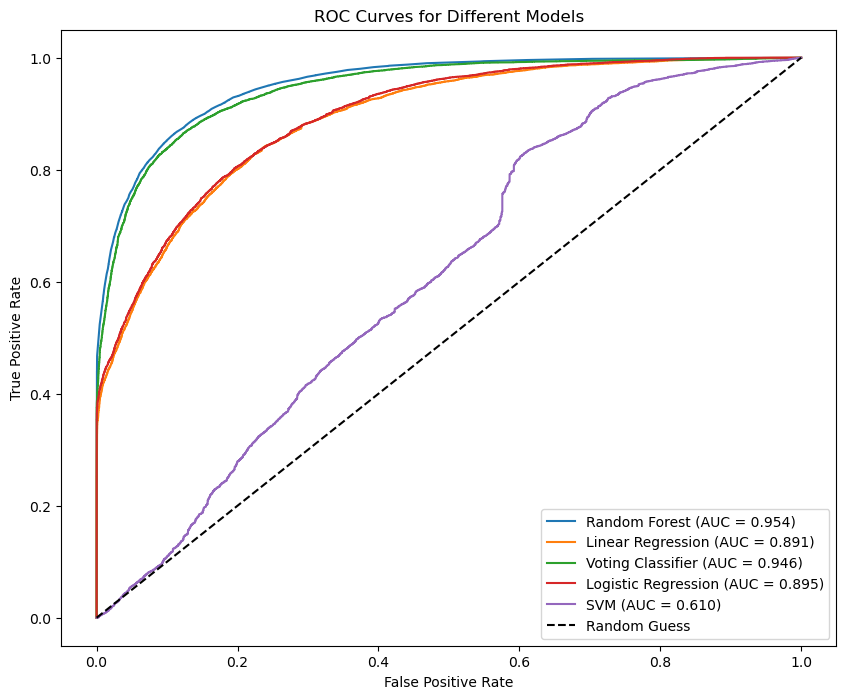

In [ ]:
classifiers = {'Random Forest': clf2, 'Linear Regression': clf3, 'Voting Classifier': clf4, 'Logistic Regression': clf_log, 'SVM': clf_SVM}
plotROC(classifiers, x_test, y_test)

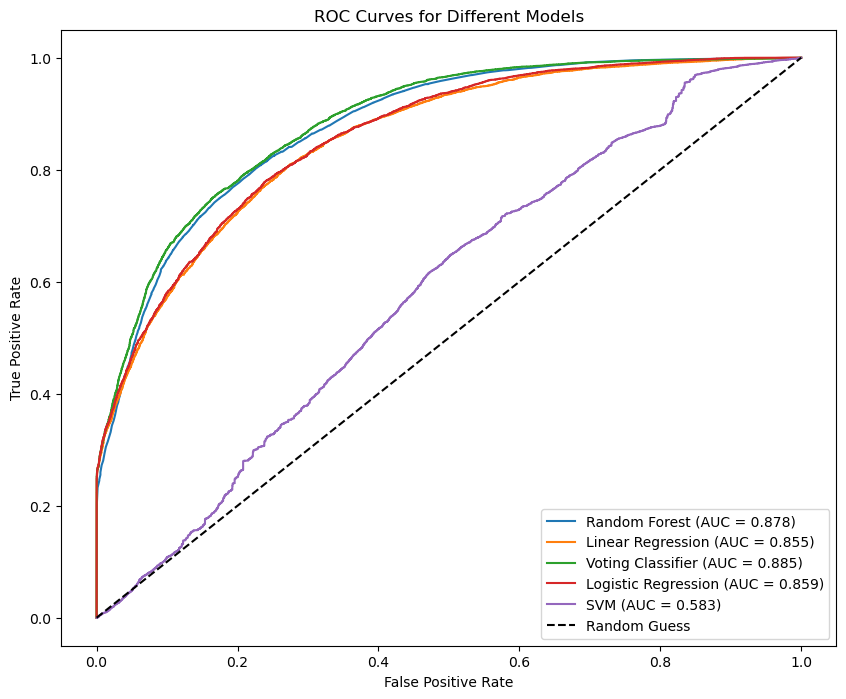

In [ ]:
classifiers = {'Random Forest': clf2_, 'Linear Regression': clf3_, 'Voting Classifier': clf4_, 'Logistic Regression': clf_log_, 'SVM': clf_SVM_}
plotROC(classifiers, x_test2, y_test2)

In [ ]:
def predict(clf, x):
    return clf.predict(np.array(x).reshape(1, -1))[0]

In [ ]:
# Делаем прогноз для конкретной записи в обучающем множестве
x = x_train[2000]
prediction = predict(clf2, x) # Сделаем предсказание, используя обученный классификатор
actual_value = y_train[2000]

print(f'Прогнозируемое значение: {prediction}')
print(f'Фактическое значение: {actual_value}')

Прогнозируемое значение: 0
Фактическое значение: 0
